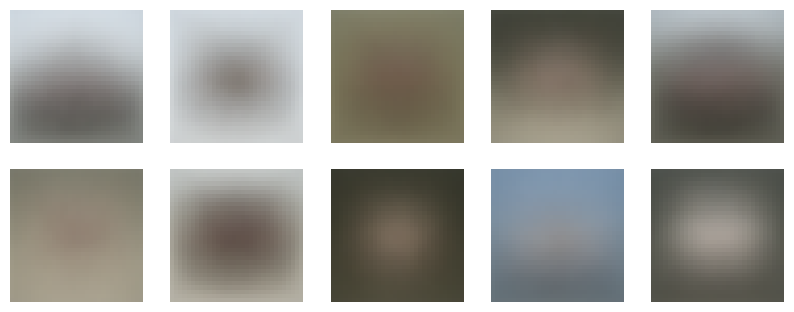

Accuracy: 22.69%


In [11]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import cifar10
from scipy.stats import mode

# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Preprocess the data
# Flatten the images and normalize pixel values
x_train = x_train.reshape((x_train.shape[0], -1)).astype('float32') / 255.0
x_test = x_test.reshape((x_test.shape[0], -1)).astype('float32') / 255.0

# K-means algorithm
class KMeans:
    def __init__(self, n_clusters=10, max_iter=300, tol=1e-4):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol
        self.centroids = None

    def fit(self, X):
        # Randomly initialize centroids
        random_indices = np.random.choice(X.shape[0], self.n_clusters, replace=False)
        self.centroids = X[random_indices]

        for i in range(self.max_iter):
            # Assign clusters
            distances = self._compute_distances(X)
            labels = np.argmin(distances, axis=1)

            # Save the old centroids for convergence check
            old_centroids = self.centroids.copy()

            # Update centroids
            for j in range(self.n_clusters):
                if len(X[labels == j]) > 0:  # Avoid empty clusters
                    self.centroids[j] = X[labels == j].mean(axis=0)

            # Check for convergence
            if np.linalg.norm(self.centroids - old_centroids) < self.tol:
                break

        return labels  # Return the labels for the training data

    def _compute_distances(self, X):
        # Compute the distance from each point to each centroid
        return np.linalg.norm(X[:, np.newaxis] - self.centroids, axis=2)

    def predict(self, X):
        distances = self._compute_distances(X)
        return np.argmin(distances, axis=1)

    def assign_labels(self, true_labels, predicted_labels):
      label_mapping = {}
      for cluster in range(self.n_clusters):
        # Get true labels of the data points in this cluster
        cluster_labels = true_labels[predicted_labels == cluster]

        if len(cluster_labels) > 0:  # Ensure the cluster is not empty
            most_common_label = mode(cluster_labels, keepdims=True)  # Use keepdims=True for newer SciPy versions
            label_mapping[cluster] = int(most_common_label.mode[0])  # Convert to int for compatibility
        else:
            label_mapping[cluster] = 0  # Assign a default label for empty clusters

      return label_mapping

    def calculate_accuracy(self, true_labels, predicted_labels):
      correct_predictions = 0
      for cluster in range(self.n_clusters):
        # Get the true labels for the points in this cluster
        cluster_labels = true_labels[predicted_labels == cluster]

        if len(cluster_labels) > 0:
            # Ensure mode() always returns an array
            most_common_label = mode(cluster_labels, keepdims=True)
            most_common_label = most_common_label.mode[0] if most_common_label.mode.size > 0 else 0

            # Count correct predictions
            correct_predictions += np.sum(cluster_labels == most_common_label)

      return correct_predictions / len(true_labels)

# Run K-means on CIFAR-10
kmeans = KMeans(n_clusters=10)
predicted_labels = kmeans.fit(x_train)

# Assign the most common true label to each cluster
label_mapping = kmeans.assign_labels(y_train.flatten(), predicted_labels)

# Map predicted labels to true labels
mapped_labels = np.array([label_mapping[label] for label in predicted_labels])

# Visualize the centroids
def plot_centroids(centroids):
    plt.figure(figsize=(10, 10))
    for i in range(centroids.shape[0]):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(centroids[i].reshape(32, 32, 3))
        plt.axis('off')
    plt.show()

plot_centroids(kmeans.centroids)

# Calculate accuracy
accuracy = kmeans.calculate_accuracy(y_train.flatten(), predicted_labels)
print(f'Accuracy: {accuracy * 100:.2f}%')